# Лабораторная работа 3.1 Анализ и визуализация временного ряда бизнес-показателей


**Цель работы.** Освоить ключевые методы анализа временных рядов на языке Python для решения практических бизнес-задач, таких как прогнозирование, выявление трендов и сезонности в экономических показателях.

## Введение. Почему временные ряды важны для бизнеса?

Временные ряды — это наборы данных, где каждая точка привязана к определенному моменту времени. Для бизнес-информатики это один из самых ценных активов, позволяющий:

- **Прогнозировать спрос.** Оптимизировать запасы и логистику.
- **Анализировать финансовые рынки.** Предсказывать цены акций и курсы валют.
- **Оценивать эффективность маркетинга.** Отслеживать влияние рекламных кампаний на продажи во времени.
- **Планировать ресурсы.** Прогнозировать нагрузку на серверы или количество обращений в колл-центр.

В этой работе мы научимся извлекать из временных данных ценные инсайты, строить и оценивать прогнозные модели.

### Основные характеристики временных рядов

- **Тренд (Trend).** Долгосрочное направление движения ряда (рост, падение, стагнация).
- **Сезонность (Seasonality).** Периодические, повторяющиеся колебания (например, рост продаж перед Новым годом).
- **Циклы (Cycles).** Долгосрочные волнообразные колебания, не связанные с фиксированным периодом, как у сезонности (например, экономические циклы).
- **Шум (Noise/Residual).** Случайные, непрогнозируемые колебания.
- **Стационарность.** Свойство ряда, при котором его статистические характеристики (среднее, дисперсия) не меняются со временем. Большинство моделей требуют, чтобы ряд был стационарным.

## Часть 1. Подготовка к анализу

Перед началом работы установим и импортируем все необходимые библиотеки.

In [3]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn -q

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Работа с датами и временем в Pandas

Правильная работа с временными метками — основа анализа временных рядов. Pandas предоставляет мощный инструментарий для этого.

**Задание 1. Создание DataFrame и преобразование в формат даты**

Создайте DataFrame на основе предоставленных данных о продажах. Преобразуйте столбец `'Дата'` в специальный формат `datetime` с помощью `pd.to_datetime()` и выведите типы данных DataFrame с помощью `.info()`.

In [5]:
data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}

# 1. Создайте DataFrame 'df' из словаря 'data'
df = pd.DataFrame(data)

# 2. Преобразуйте столбец 'Дата' в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'])

# 3. Выведите информацию о DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Дата     5 non-null      datetime64[ns]
 1   Продажи  5 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 212.0 bytes


**Задание 2. Установка временного индекса**

Для удобной работы с временными рядами столбец с датами часто устанавливают в качестве индекса DataFrame. Используйте метод `.set_index()` для установки столбца `'Дата'` в качестве индекса.

In [6]:
# Ваш код здесь
# Установите 'Дата' в качестве индекса для df
df = df.set_index('Дата')

**Задание 3. Фильтрация данных по дате**

Используя временной индекс, выберите данные о продажах за период с марта по апрель 2023 года включительно.

In [7]:
# Ваш код здесь
selected_data = df['2023-03':'2023-04']
selected_data



,Продажи
Дата,
2023-03-01,1300
2023-04-01,1100


### Обработка пропущенных значений

Реальные бизнес-данные часто содержат пропуски. Их корректная обработка — критически важный шаг.

**Задание 4. Обнаружение пропущенных значений**

Создайте новый DataFrame `df_missing` с пропущенным значением. Используйте `.isnull().sum()` для подсчета количества пропусков в каждом столбце.

In [8]:
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                  'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

# Ваш код здесь
# Посчитайте пропущенные значения
missing_values = df_missing.isnull().sum()
missing_values


,0
Продажи,1


**Задание 5. Заполнение пропусков средним значением**

Заполните пропущенное значение в столбце `'Продажи'` средним значением этого же столбца. Это более robustный подход, чем заполнение нулем. Не забудьте переприсвоить результат.

In [9]:
# Ваш код здесь
# 1. Рассчитайте среднее по столбцу 'Продажи' (игнорируя NaN)
sales_mean = df_missing['Продажи'].mean()
print(f"Среднее значение продаж: {sales_mean}")

# 2. Заполните пропуски с помощью .fillna() и переприсвойте результат
df_missing['Продажи'] = df_missing['Продажи'].fillna(sales_mean)



Среднее значение продаж: 1200.0


**Задание 6. Заполнение пропусков методом интерполяции**

Интерполяция заполняет пропуски, вычисляя промежуточные значения между двумя известными точками. Это часто дает более реалистичный результат. Примените метод `.interpolate()` к `df_missing`.

In [10]:
# Ваш код здесь
# Восстановим исходные данные с пропуском для демонстрации интерполяции
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

# Применение метода интерполяции
df_missing['Продажи'] = df_missing['Продажи'].interpolate()

print("\nДанные после интерполяции:")
print(df_missing)
print(f"\nКоличество пропусков после интерполяции: {df_missing.isnull().sum()['Продажи']}")



Данные после интерполяции:
            Продажи
Дата               
2023-01-01   1000.0
2023-02-01   1150.0
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0

Количество пропусков после интерполяции: 0


## Часть 2. Исследовательский анализ временных рядов (EDA)

На этом этапе мы будем использовать реальный набор данных о ежемесячном производстве бензина в США. Наша цель — визуализировать данные и выявить их основные компоненты.

**Задание 7. Загрузка и подготовка данных**

Загрузите данные по ссылке. Убедитесь, что столбец с датой преобразован в `datetime` и установлен в качестве индекса. Выведите первые 5 строк.

In [11]:
# Ваш код здесь
gas_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_gasoline_production.csv"

# Загрузите данные, используя parse_dates=['date'] и index_col='date'
gas_data = pd.read_csv(gas_url, parse_dates=['date'], index_col='date')

# Выведите первые 5 строк
print("Первые 5 строк данных:")
print(gas_data.head())
print("\nИнформация о данных:")
print(gas_data.info())


Первые 5 строк данных:
            value
date             
1991-02-03  6.621
1991-02-10  6.433
1991-02-17  6.582
1991-02-24  7.224
1991-03-03  6.875

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1355 entries, 1991-02-03 to 2017-01-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1355 non-null   float64
dtypes: float64(1)
memory usage: 21.2 KB
None


**Задание 8. Визуализация временного ряда**

Постройте линейный график для столбца `'value'`, чтобы визуально оценить данные. Добавьте заголовок и подписи осей.

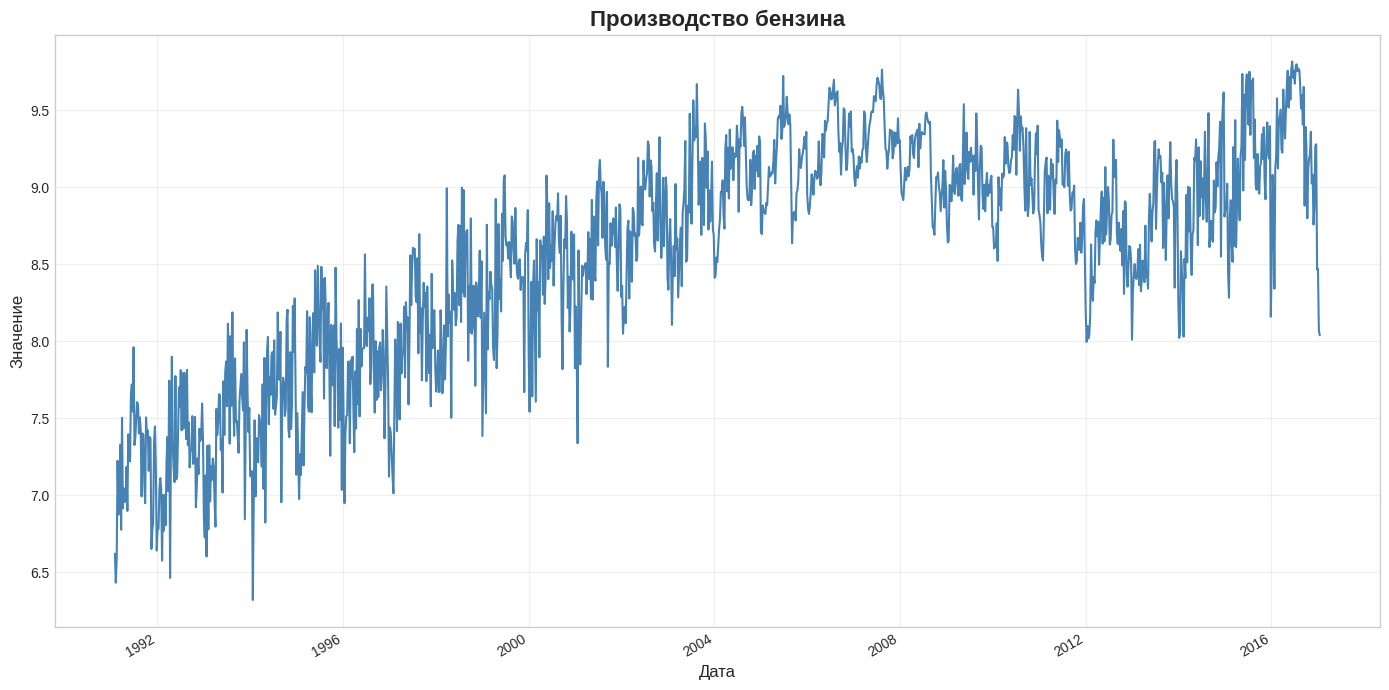

In [12]:
# Ваш код здесь
plt.figure(figsize=(14, 7))

# Построение графика для столбца 'value'
plt.plot(gas_data.index, gas_data['value'],
         color='steelblue', linewidth=1.5)

# Добавление заголовка и подписей осей
plt.title('Производство бензина',
          fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значение', fontsize=12)

# Настройка сетки
plt.grid(True, alpha=0.3)

# Форматирование оси X для лучшей читаемости дат
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

**Задание 9. Ресэмплинг для агрегации данных**

Исходные данные имеют еженедельную частоту, что делает график 'шумным'. Преобразуйте ряд в ежемесячный (`'M'`), агрегируя значения с помощью среднего (`.mean()`). Сохраните результат в `gas_monthly` и постройте график.

/tmp/ipython-input-1239089010.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gas_monthly = gas_data.resample('M').mean()


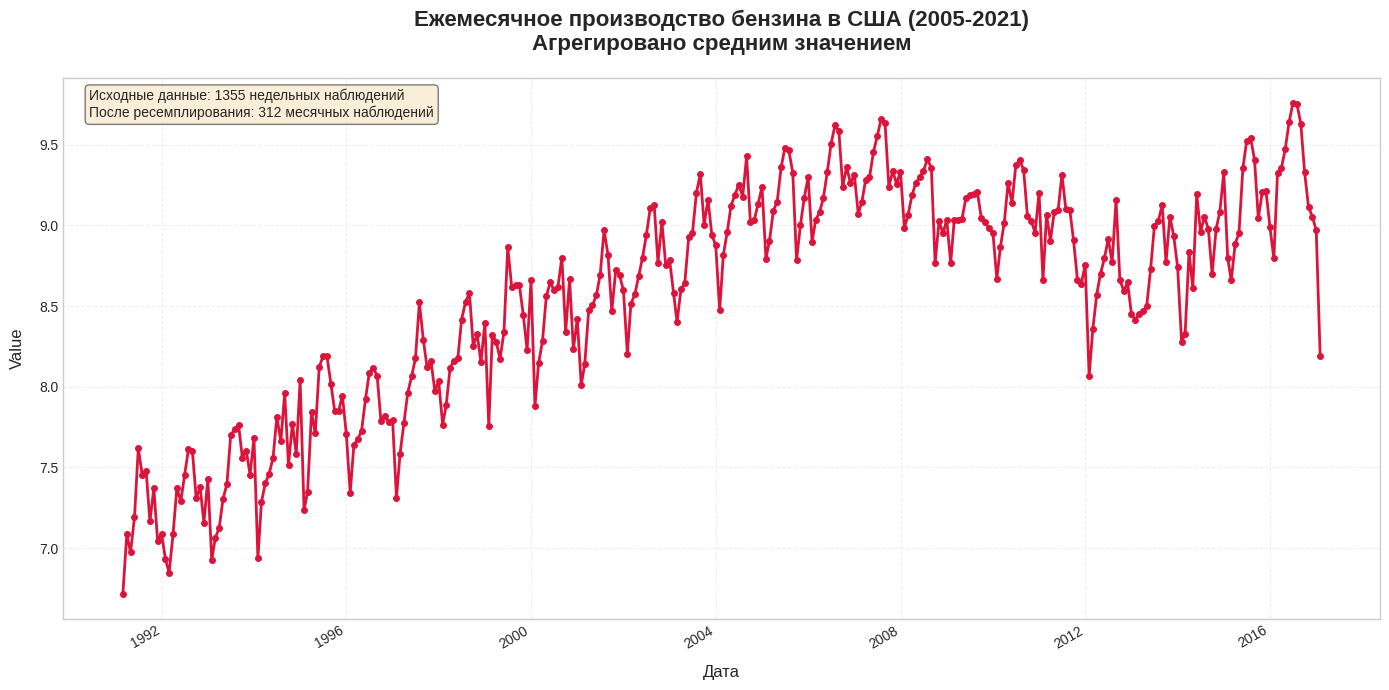

In [13]:
# Ваш код здесь
# 1. Выполните ресэмплинг
gas_monthly = gas_data.resample('M').mean()


# 2. Постройте график для gas_monthly['value']
# Построение графика ежемесячных данных
plt.figure(figsize=(14, 7))

# Определяем имя столбца
column_name = gas_monthly.columns[0]

# Построение графика
plt.plot(gas_monthly.index, gas_monthly[column_name],
         color='crimson', linewidth=2, marker='o', markersize=4)

# Добавление заголовка и подписей осей
plt.title('Ежемесячное производство бензина в США (2005-2021)\nАгрегировано средним значением',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=12, labelpad=10)
plt.ylabel(f'{column_name.capitalize()}', fontsize=12, labelpad=10)

# Настройка сетки
plt.grid(True, alpha=0.3, linestyle='--')

# Настройка формата дат на оси X
plt.gcf().autofmt_xdate()

# Добавление аннотации
plt.text(0.02, 0.98,
         f'Исходные данные: {len(gas_data)} недельных наблюдений\n'
         f'После ресемплирования: {len(gas_monthly)} месячных наблюдений',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

**Задание 10. Сглаживание с помощью скользящего среднего**

Чтобы лучше увидеть долгосрочный тренд, примените скользящее среднее. Создайте новый столбец `'rolling_mean_12'` в `gas_monthly`, рассчитав среднее за 12 месяцев с помощью `.rolling(window=12).mean()`. Постройте на одном графике исходный ряд и сглаженный.

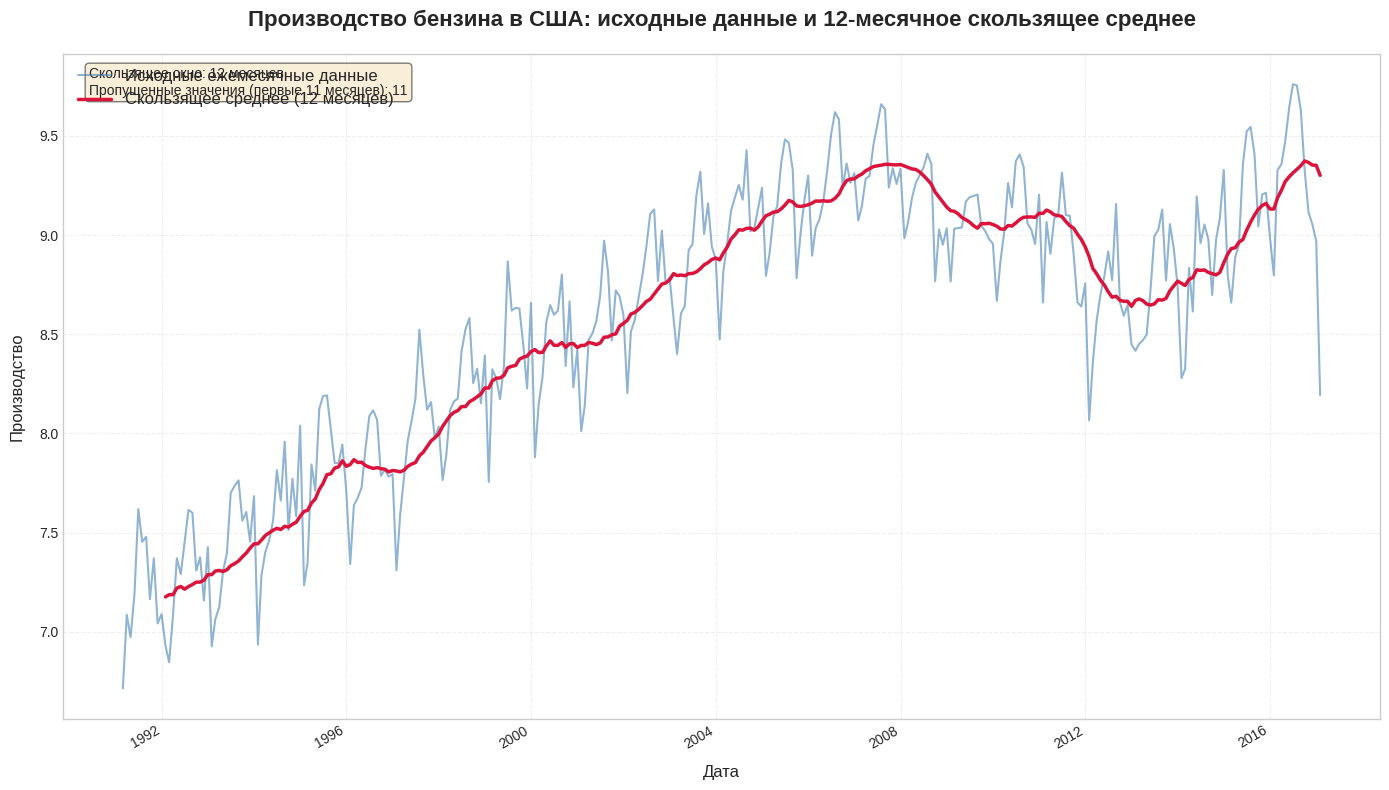

In [14]:
# Ваш код здесь
# 1. Рассчитайте скользящее среднее за 12 месяцев
gas_monthly['rolling_mean_12'] = gas_monthly.iloc[:, 0].rolling(window=12).mean()

# 2. Постройте графики исходного ряда и сглаженного
plt.figure(figsize=(14, 8))

# Получаем имя основного столбца
main_column = gas_monthly.columns[0]

# Построение исходного ряда
plt.plot(gas_monthly.index, gas_monthly[main_column],
         color='steelblue', linewidth=1.5, alpha=0.6,
         label='Исходные ежемесячные данные')

# Построение скользящего среднего
plt.plot(gas_monthly.index, gas_monthly['rolling_mean_12'],
         color='crimson', linewidth=2.5,
         label='Скользящее среднее (12 месяцев)')

# Добавление заголовка и подписей осей
plt.title('Производство бензина в США: исходные данные и 12-месячное скользящее среднее',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=12, labelpad=10)
plt.ylabel('Производство', fontsize=12, labelpad=10)

# Настройка сетки
plt.grid(True, alpha=0.3, linestyle='--')

# Легенда
plt.legend(loc='upper left', fontsize=12)

# Настройка формата дат на оси X
plt.gcf().autofmt_xdate()

# Добавление аннотации
plt.text(0.02, 0.98,
         f'Скользящее окно: 12 месяцев\n'
         f'Пропущенные значения (первые 11 месяцев): {gas_monthly["rolling_mean_12"].isnull().sum()}',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))



plt.tight_layout()
plt.show()

**Задание 11. Декомпозиция временного ряда**

Используйте `seasonal_decompose` из `statsmodels`, чтобы разложить ежемесячный ряд `gas_monthly['value']` на тренд, сезонность и остаток. Визуализируйте результат с помощью метода `.plot()`.

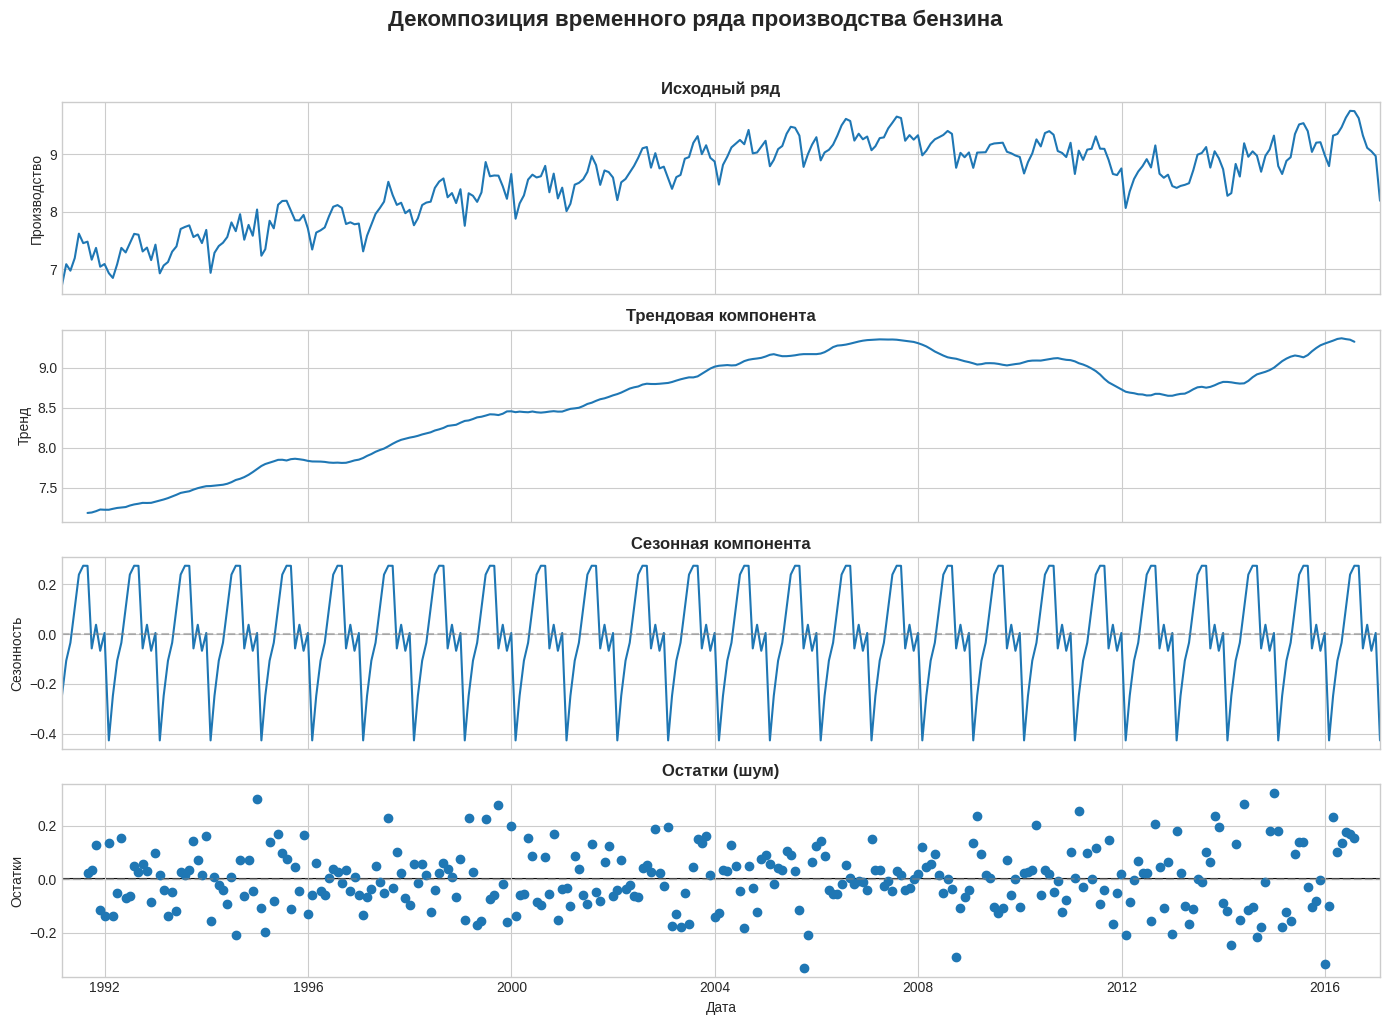

In [15]:
# Ваш код здесь
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Выполнение декомпозиции временного ряда
# Указываем период сезонности (12 месяцев для ежемесячных данных)
decomposition = seasonal_decompose(gas_monthly.iloc[:, 0],
                                   model='additive',
                                   period=12)

# 2. Построение графика декомпозиции
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Декомпозиция временного ряда производства бензина',
             fontsize=16, fontweight='bold', y=1.02)

# Улучшение внешнего вида графиков
axes = fig.axes

# Настройка верхнего графика (исходный ряд)
axes[0].set_title('Исходный ряд', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Производство', fontsize=10)

# Настройка второго графика (тренд)
axes[1].set_title('Трендовая компонента', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Тренд', fontsize=10)

# Настройка третьего графика (сезонность)
axes[2].set_title('Сезонная компонента', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Сезонность', fontsize=10)
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # горизонтальная линия на 0

# Настройка нижнего графика (остатки)
axes[3].set_title('Остатки (шум)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Дата', fontsize=10)
axes[3].set_ylabel('Остатки', fontsize=10)
axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # горизонтальная линия на 0

plt.tight_layout()
plt.show()


## Часть 3. Стационарность и корреляционный анализ

**Задание 12. Проверка на стационарность**

Проведите расширенный тест Дики-Фуллера (`adfuller`) для ряда `gas_monthly['value']`. Проанализируйте p-значение и сделайте вывод о стационарности ряда.

In [16]:
# Ваш код здесь
from statsmodels.tsa.stattools import adfuller

# Проведение расширенного теста Дики-Фуллера (ADF-тест)
result = adfuller(gas_monthly.iloc[:, 0])

print("РЕЗУЛЬТАТЫ РАСШИРЕННОГО ТЕСТА ДИКИ-ФУЛЛЕРА")
print("=" * 60)

# Извлечение и форматирование результатов
adf_statistic = result[0]
p_value = result[1]
used_lags = result[2]
n_observations = result[3]
critical_values = result[4]

print(f"ADF статистика: {adf_statistic:.6f}")
print(f"P-значение: {p_value:.6f}")
print(f"Использовано лагов: {used_lags}")
print(f"Количество наблюдений: {n_observations}")
print("\nКритические значения:")
for key, value in critical_values.items():
    print(f"  {key}: {value:.6f}")

print("\n" + "=" * 60)
print("ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
print("=" * 60)

# Проверка гипотез
if p_value < 0.05:
    print("✓ ОТКЛОНЯЕМ нулевую гипотезу (H0)")
    print("  Ряд СТАЦИОНАРЕН (не имеет единичного корня)")
    print(f"  P-значение ({p_value:.6f}) < 0.05")
else:
    print("✓ НЕ ОТКЛОНЯЕМ нулевую гипотезу (H0)")
    print("  Ряд НЕСТАЦИОНАРЕН (имеет единичный корень)")
    print(f"  P-значение ({p_value:.6f}) > 0.05")



РЕЗУЛЬТАТЫ РАСШИРЕННОГО ТЕСТА ДИКИ-ФУЛЛЕРА
ADF статистика: -2.197750
P-значение: 0.207063
Использовано лагов: 16
Количество наблюдений: 295

Критические значения:
  1%: -3.452713
  5%: -2.871388
  10%: -2.572017

ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:
✓ НЕ ОТКЛОНЯЕМ нулевую гипотезу (H0)
  Ряд НЕСТАЦИОНАРЕН (имеет единичный корень)
  P-значение (0.207063) > 0.05


**Задание 13. Достижение стационарности через дифференцирование**

Чтобы сделать ряд стационарным, примените к нему дифференцирование первого порядка с помощью метода `.diff()`. Удалите появившееся значение `NaN` и сохраните результат в `gas_monthly_diff`.

Результат дифференцирования первого порядка:
Первые 5 значений:
date
1991-03-31    0.37100
1991-04-30   -0.11275
1991-05-31    0.21850
1991-06-30    0.42725
1991-07-31   -0.16575
Freq: ME, Name: value, dtype: float64

Последние 5 значений:
date
2016-09-30   -0.300250
2016-10-31   -0.216300
2016-11-30   -0.060200
2016-12-31   -0.083500
2017-01-31   -0.778833
Freq: ME, Name: value, dtype: float64

Размер после удаления NaN: 311
Количество пропусков: 0


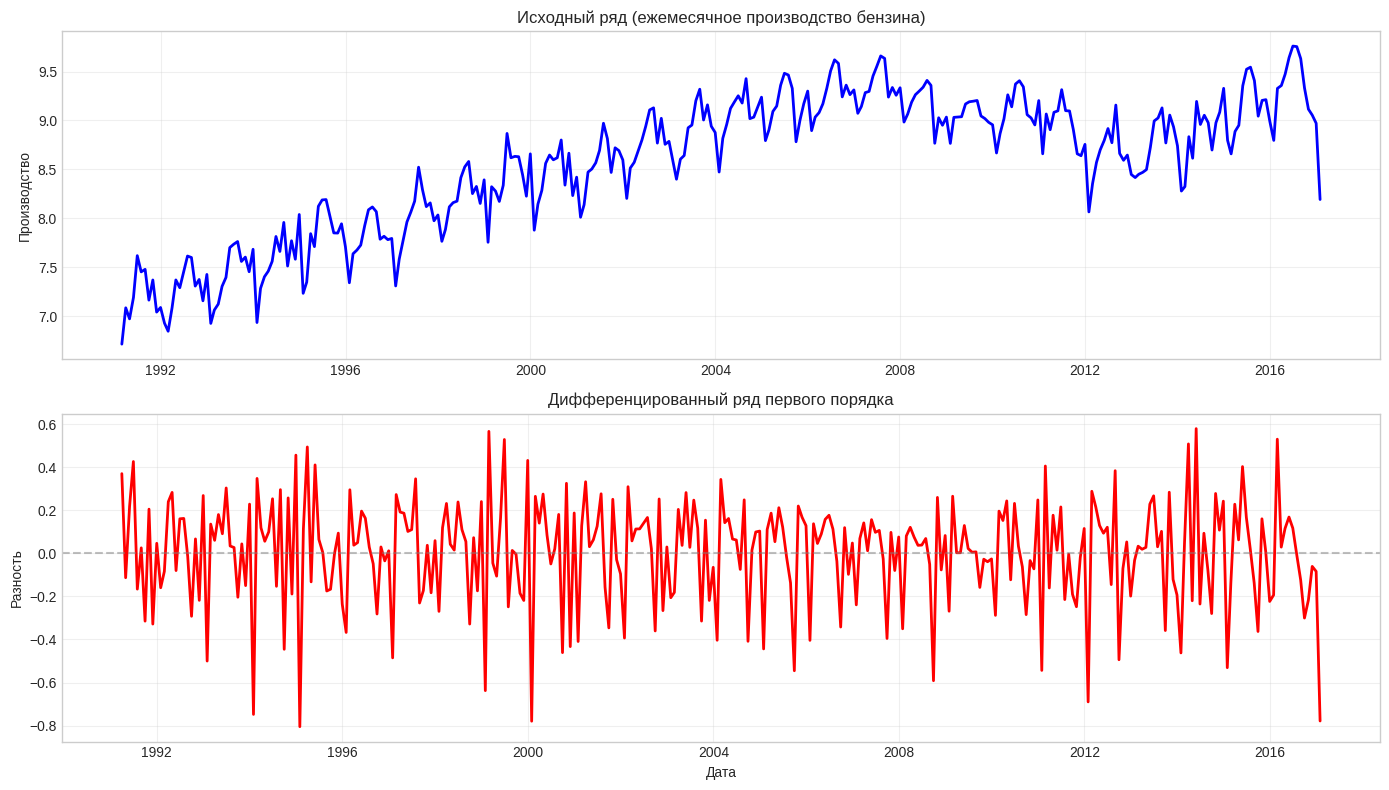


Проверка стационарности после дифференцирования:
ADF статистика: -3.063923
P-значение: 0.029341
✓ Дифференцированный ряд СТАЦИОНАРЕН (p-value < 0.05)


In [17]:
# Ваш код здесь
# Применение дифференцирования первого порядка
gas_monthly_diff = gas_monthly.iloc[:, 0].diff()

# Удаление NaN-значения (первая строка после diff())
gas_monthly_diff = gas_monthly_diff.dropna()

# Проверка результата
print("Результат дифференцирования первого порядка:")
print(f"Первые 5 значений:\n{gas_monthly_diff.head()}")
print(f"\nПоследние 5 значений:\n{gas_monthly_diff.tail()}")
print(f"\nРазмер после удаления NaN: {len(gas_monthly_diff)}")
print(f"Количество пропусков: {gas_monthly_diff.isnull().sum()}")

# Визуализация исходного ряда и дифференцированного
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Исходный ряд
ax1.plot(gas_monthly.index, gas_monthly.iloc[:, 0], 'b-', linewidth=2)
ax1.set_title('Исходный ряд (ежемесячное производство бензина)', fontsize=12)
ax1.set_ylabel('Производство')
ax1.grid(True, alpha=0.3)

# Дифференцированный ряд
ax2.plot(gas_monthly_diff.index, gas_monthly_diff, 'r-', linewidth=2)
ax2.set_title('Дифференцированный ряд первого порядка', fontsize=12)
ax2.set_xlabel('Дата')
ax2.set_ylabel('Разность')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка стационарности дифференцированного ряда
adf_result_diff = adfuller(gas_monthly_diff)
print("\nПроверка стационарности после дифференцирования:")
print(f"ADF статистика: {adf_result_diff[0]:.6f}")
print(f"P-значение: {adf_result_diff[1]:.6f}")

if adf_result_diff[1] < 0.05:
    print("✓ Дифференцированный ряд СТАЦИОНАРЕН (p-value < 0.05)")
else:
    print("✗ Дифференцированный ряд всё ещё НЕСТАЦИОНАРЕН (p-value ≥ 0.05)")

**Задание 14. Повторная проверка на стационарность**

Проведите тест Дики-Фуллера для нового, дифференцированного ряда `gas_monthly_diff`. Сравните p-значение с предыдущим результатом.

In [18]:
# Ваш код здесь
# Проведение теста Дики-Фуллера для дифференцированного ряда
result_diff = adfuller(gas_monthly_diff)

print("ТЕСТ ДИКИ-ФУЛЛЕРА ДЛЯ ДИФФЕРЕНЦИРОВАННОГО РЯДА")
print("=" * 50)

print(f"ADF статистика: {result_diff[0]:.6f}")
print(f"P-значение: {result_diff[1]:.6f}")
print(f"Использовано лагов: {result_diff[2]}")
print(f"Количество наблюдений: {result_diff[3]}")

print("\nКритические значения:")
for key, value in result_diff[4].items():
    print(f"  {key}: {value:.6f}")

print("\n" + "=" * 50)
print("СРАВНЕНИЕ С ИСХОДНЫМ РЯДОМ")
print("=" * 50)

# Получаем результаты для исходного ряда (из задания 12)
result_original = adfuller(gas_monthly.iloc[:, 0])

print(f"{'Параметр':<20} {'Исходный ряд':<15} {'Дифференцированный':<15}")
print("-" * 50)
print(f"{'ADF статистика':<20} {result_original[0]:<15.6f} {result_diff[0]:<15.6f}")
print(f"{'P-значение':<20} {result_original[1]:<15.6f} {result_diff[1]:<15.6f}")

print("\n" + "=" * 50)
print("ВЫВОДЫ:")
print("=" * 50)

if result_original[1] >= 0.05 and result_diff[1] < 0.05:
    print("✓ Дифференцирование ПОМОГЛО:")
    print(f"  - Исходный ряд: p-value = {result_original[1]:.6f} ≥ 0.05 → НЕСТАЦИОНАРЕН")
    print(f"  - Дифференцированный: p-value = {result_diff[1]:.6f} < 0.05 → СТАЦИОНАРЕН")
elif result_original[1] < 0.05:
    print("⚠ Исходный ряд уже был стационарным")
    print(f"  Исходный p-value = {result_original[1]:.6f} < 0.05")
else:
    print("✗ Дифференцирование НЕ ПОМОГЛО, нужны дополнительные преобразования")
    print(f"  Исходный p-value = {result_original[1]:.6f} ≥ 0.05")
    print(f"  Дифференцированный p-value = {result_diff[1]:.6f} ≥ 0.05")






ТЕСТ ДИКИ-ФУЛЛЕРА ДЛЯ ДИФФЕРЕНЦИРОВАННОГО РЯДА
ADF статистика: -3.063923
P-значение: 0.029341
Использовано лагов: 16
Количество наблюдений: 294

Критические значения:
  1%: -3.452790
  5%: -2.871422
  10%: -2.572035

СРАВНЕНИЕ С ИСХОДНЫМ РЯДОМ
Параметр             Исходный ряд    Дифференцированный
--------------------------------------------------
ADF статистика       -2.197750       -3.063923      
P-значение           0.207063        0.029341       

ВЫВОДЫ:
✓ Дифференцирование ПОМОГЛО:
  - Исходный ряд: p-value = 0.207063 ≥ 0.05 → НЕСТАЦИОНАРЕН
  - Дифференцированный: p-value = 0.029341 < 0.05 → СТАЦИОНАРЕН


**Задание 15. Анализ автокорреляции (ACF)**

Постройте график автокорреляционной функции (ACF) для стационарного ряда `gas_monthly_diff`. Это поможет определить порядок компоненты MA в модели ARIMA.

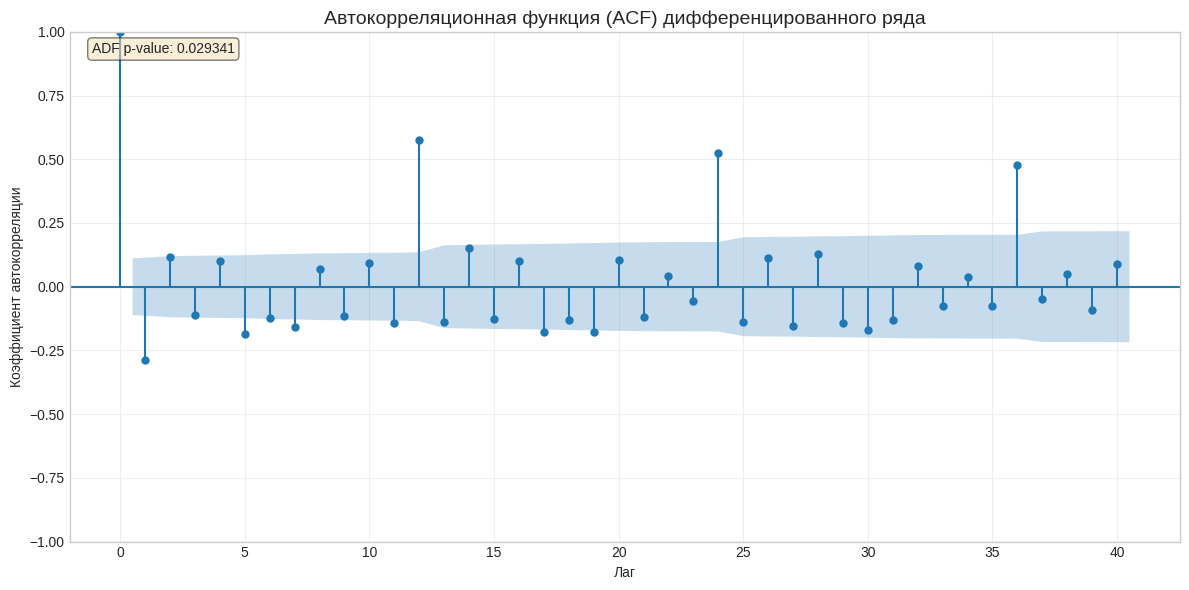

In [20]:
# Ваш код здесь

# Используйте plot_acf, передав в него ряд и ax

from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12, 6))

# Построение ACF для дифференцированного ряда
plot_acf(gas_monthly_diff, lags=40, ax=ax, alpha=0.05)

# Настройка графика
ax.set_title('Автокорреляционная функция (ACF) дифференцированного ряда', fontsize=14)
ax.set_xlabel('Лаг')
ax.set_ylabel('Коэффициент автокорреляции')
ax.grid(True, alpha=0.3)

# Добавление информации о стационарности
adf_result = adfuller(gas_monthly_diff)
ax.text(0.02, 0.98, f'ADF p-value: {adf_result[1]:.6f}',
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()




**Задание 16. Анализ частичной автокорреляции (PACF)**

Постройте график частичной автокорреляционной функции (PACF) для `gas_monthly_diff`. Это поможет определить порядок компоненты AR в модели ARIMA.

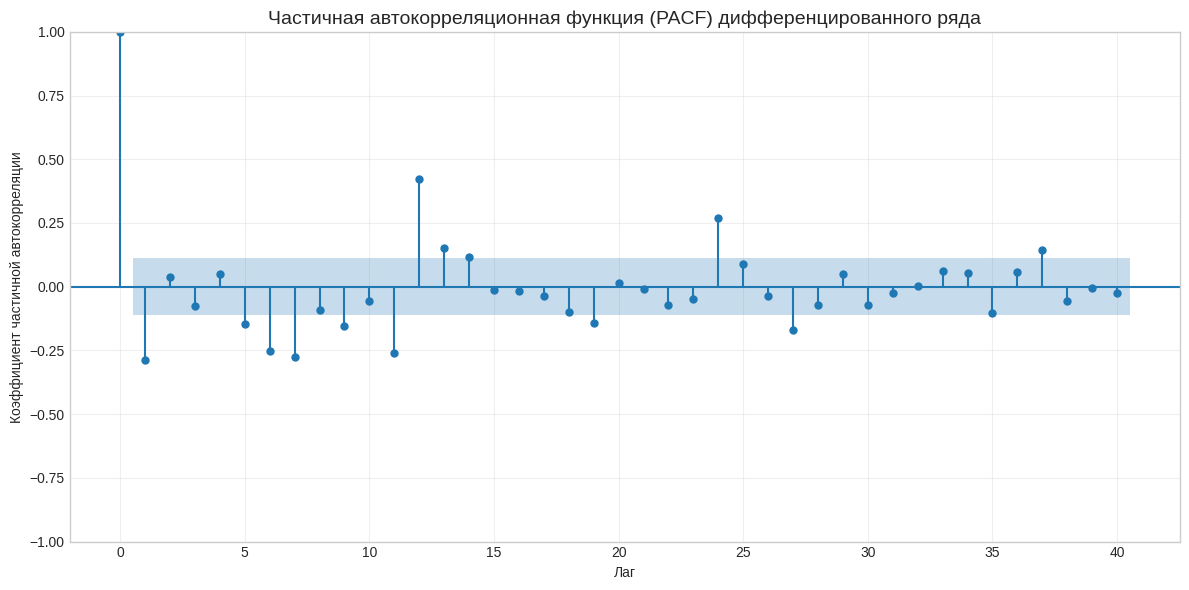

In [21]:
# Ваш код здесь

# Используйте plot_pacf, передав в него ряд и ax
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12, 6))

# Построение PACF для дифференцированного ряда
plot_pacf(gas_monthly_diff, lags=40, ax=ax, alpha=0.05, method='ywm')

# Настройка графика
ax.set_title('Частичная автокорреляционная функция (PACF) дифференцированного ряда', fontsize=14)
ax.set_xlabel('Лаг')
ax.set_ylabel('Коэффициент частичной автокорреляции')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Часть 4. Построение и оценка прогнозной модели ARIMA

Модель ARIMA (AutoRegressive Integrated Moving Average) — одна из самых популярных моделей для прогнозирования временных рядов.

- **AR (p):** Авторегрессионная часть, использующая зависимость от `p` предыдущих значений.
- **I (d):** Интегрированная часть, отвечающая за количество дифференцирований (`d`) для достижения стационарности.
- **MA (q):** Часть скользящего среднего, использующая зависимость от `q` предыдущих ошибок прогноза.

**Задание 17. Разделение данных на обучающую и тестовую выборки**

Разделите `gas_monthly['value']` на обучающую (все данные до 2015 года) и тестовую (данные с 2015 года) выборки. Это позволит нам оценить качество модели на данных, которые она не видела при обучении.

РАЗДЕЛЕНИЕ ДАННЫХ:
Обучающая выборка: 287 наблюдений
  Диапазон: с 1991-02-28 00:00:00 по 2014-12-31 00:00:00
Тестовая выборка: 25 наблюдений
  Диапазон: с 2015-01-31 00:00:00 по 2017-01-31 00:00:00
Всего данных: 312 наблюдений


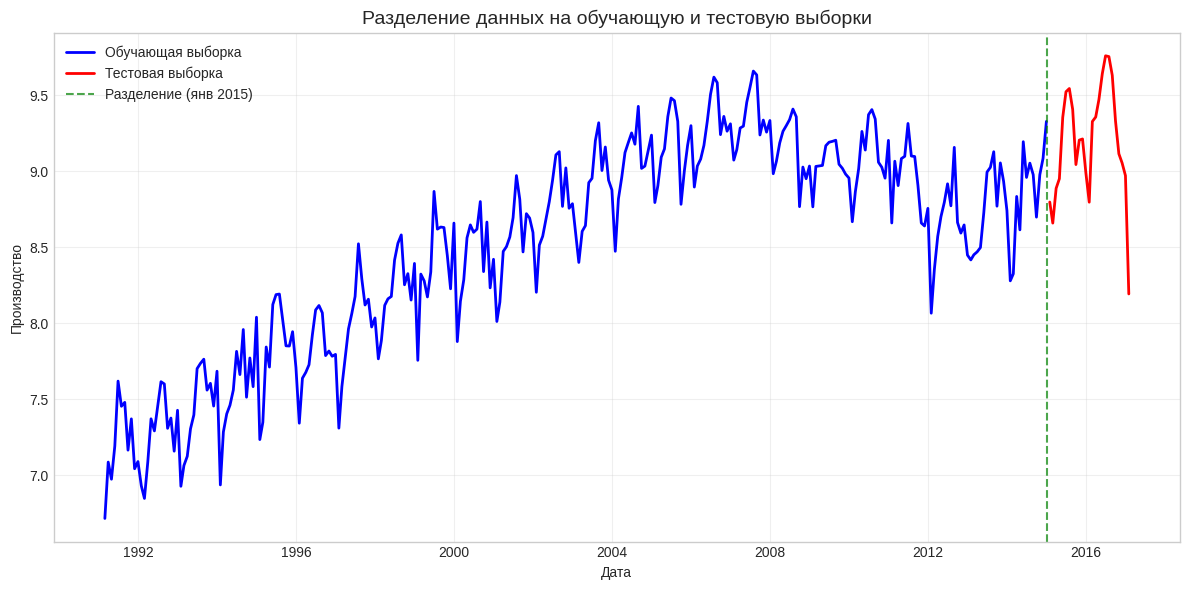

In [22]:
# Ваш код здесь
# Разделение данных на обучающую и тестовую выборки
train_data = gas_monthly.loc[gas_monthly.index < '2015-01-01'].iloc[:, 0]
test_data = gas_monthly.loc[gas_monthly.index >= '2015-01-01'].iloc[:, 0]

# Проверка разделения
print("РАЗДЕЛЕНИЕ ДАННЫХ:")
print("=" * 50)
print(f"Обучающая выборка: {len(train_data)} наблюдений")
print(f"  Диапазон: с {train_data.index.min()} по {train_data.index.max()}")
print(f"Тестовая выборка: {len(test_data)} наблюдений")
print(f"  Диапазон: с {test_data.index.min()} по {test_data.index.max()}")
print(f"Всего данных: {len(gas_monthly)} наблюдений")

# Визуализация разделения
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, 'b-', linewidth=2, label='Обучающая выборка')
plt.plot(test_data.index, test_data, 'r-', linewidth=2, label='Тестовая выборка')
plt.axvline(x=pd.Timestamp('2015-01-01'), color='green', linestyle='--', alpha=0.7, label='Разделение (янв 2015)')
plt.title('Разделение данных на обучающую и тестовую выборки', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Производство')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Задание 18. Обучение модели ARIMA**

Обучите модель ARIMA на обучающей выборке (`train_data`). На основе графиков ACF/PACF и того, что мы применили одно дифференцирование, выберем порядок `(p, d, q) = (2, 1, 2)`. Выведите сводку по модели с помощью `.summary()`.

In [23]:
# Ваш код здесь
from statsmodels.tsa.arima.model import ARIMA

# 1. Создание модели ARIMA
model = ARIMA(train_data, order=(2, 1, 2))

# 2. Обучение модели
model_fit = model.fit()

# 3. Вывод сводки по модели
print(model_fit.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  287
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  38.541
Date:                Mon, 08 Dec 2025   AIC                            -67.083
Time:                        19:34:46   BIC                            -48.803
Sample:                    02-28-1991   HQIC                           -59.756
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4038      0.086     -4.695      0.000      -0.572      -0.235
ar.L2          0.5961      0.086      6.952      0.000       0.428       0.764
ma.L1          0.1028      0.062      1.658      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Задание 19. Построение прогноза**

Сделайте прогноз на период, соответствующий тестовой выборке. Используйте `model_fit.predict()`, указав `start` и `end` индексы тестовой выборки.

In [24]:
# Ваш код здесь

forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Проверка результата
print("ПРОГНОЗ МОДЕЛИ ARIMA(2,1,2):")
print("=" * 50)
print(f"Начало прогноза: {forecast.index[0]}")
print(f"Конец прогноза: {forecast.index[-1]}")
print(f"Количество прогнозных значений: {len(forecast)}")
print("\nПервые 5 значений прогноза:")
print(forecast.head())
print("\nПоследние 5 значений прогноза:")
print(forecast.tail())

ПРОГНОЗ МОДЕЛИ ARIMA(2,1,2):
Начало прогноза: 2015-01-31 00:00:00
Конец прогноза: 2017-01-31 00:00:00
Количество прогнозных значений: 25

Первые 5 значений прогноза:
2015-01-31    9.115067
2015-02-28    9.127644
2015-03-31    8.995342
2015-04-30    9.056262
2015-05-31    8.952799
Freq: ME, Name: predicted_mean, dtype: float64

Последние 5 значений прогноза:
2016-09-30    8.929401
2016-10-31    9.016860
2016-11-30    8.929404
2016-12-31    9.016851
2017-01-31    8.929409
Freq: ME, Name: predicted_mean, dtype: float64


**Задание 20. Визуализация прогноза**

Постройте график, на котором будут отображены обучающие данные, реальные тестовые данные и ваш прогноз.

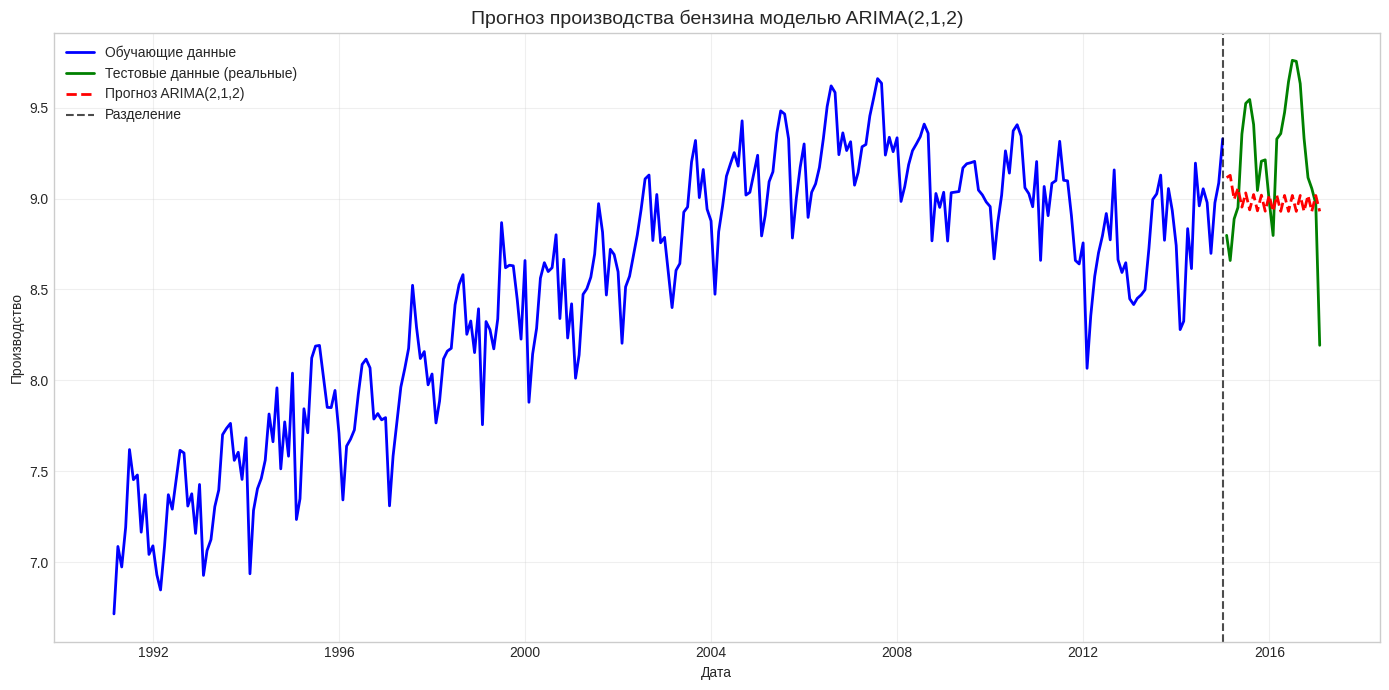

In [26]:
# Ваш код здесь
plt.figure(figsize=(14, 7))

# Обучающие данные
plt.plot(train_data.index, train_data, 'b-', linewidth=2, label='Обучающие данные')

# Тестовые данные (реальные значения)
plt.plot(test_data.index, test_data, 'g-', linewidth=2, label='Тестовые данные (реальные)')

# Прогноз модели
plt.plot(forecast.index, forecast, 'r--', linewidth=2, label='Прогноз ARIMA(2,1,2)')

# Добавьте линию для прогноза
plt.axvline(x=pd.Timestamp('2015-01-01'), color='black', linestyle='--', alpha=0.7, label='Разделение')

# Настройка графика
plt.title('Прогноз производства бензина моделью ARIMA(2,1,2)', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Производство')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Задание 21. Оценка качества модели**

Рассчитайте метрику RMSE (Root Mean Squared Error) для оценки точности вашего прогноза. RMSE = `sqrt(mean_squared_error(y_true, y_pred))`.

In [29]:
# Ваш код здесь
from sklearn.metrics import mean_squared_error

# Расчет RMSE между реальными тестовыми значениями и прогнозом
rmse = np.sqrt(mean_squared_error(test_data, forecast))

print("ОЦЕНКА ТОЧНОСТИ ПРОГНОЗА:")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"Количество прогнозных значений: {len(test_data)}")


ОЦЕНКА ТОЧНОСТИ ПРОГНОЗА:
RMSE (Root Mean Squared Error): 0.4359
Количество прогнозных значений: 25


**Задание 22. Прогноз на будущее**

Теперь, когда модель оценена, используйте ее для прогнозирования на 12 месяцев вперед (за пределы имеющихся данных). Используйте метод `.forecast()`.

In [31]:
# Ваш код здесь

future_forecast = model_fit.forecast(steps=12)

# Проверка результата
print("ПРОГНОЗ НА 12 МЕСЯЦЕВ ВПЕРЕД:")
print(f"Начало прогноза: {future_forecast.index[0]}")
print(f"Конец прогноза: {future_forecast.index[-1]}")
print(f"Количество прогнозных значений: {len(future_forecast)}")
print("\nПрогнозные значения:")
print(future_forecast)

ПРОГНОЗ НА 12 МЕСЯЦЕВ ВПЕРЕД:
Начало прогноза: 2015-01-31 00:00:00
Конец прогноза: 2015-12-31 00:00:00
Количество прогнозных значений: 12

Прогнозные значения:
2015-01-31    9.115067
2015-02-28    9.127644
2015-03-31    8.995342
2015-04-30    9.056262
2015-05-31    8.952799
2015-06-30    9.030891
2015-07-31    8.937685
2015-08-31    9.021871
2015-09-30    8.932318
2015-10-31    9.018661
2015-11-30    8.930415
2015-12-31    9.017516
Freq: ME, Name: predicted_mean, dtype: float64


**Задание 23. Визуализация прогноза на будущее**

Постройте график, включающий все исторические данные (`gas_monthly['value']`) и прогноз на будущее.

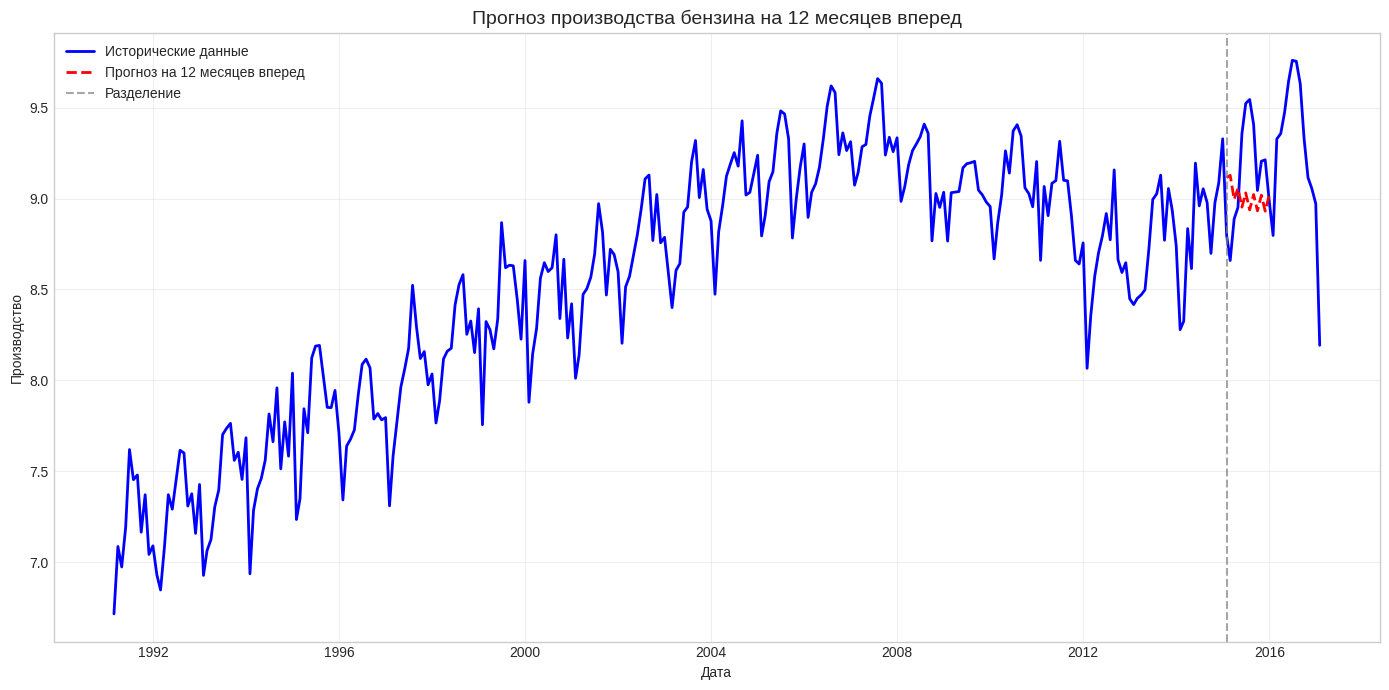

In [40]:
# Ваш код здесь
plt.figure(figsize=(14, 7))

# Все исторические данные
plt.plot(gas_monthly.index, gas_monthly.iloc[:, 0], 'b-', linewidth=2, label='Исторические данные')

# Прогноз на будущее (12 месяцев)
plt.plot(future_forecast.index, future_forecast, 'r--', linewidth=2, label='Прогноз на 12 месяцев вперед')

#Линия разделения
plt.axvline(x=pd.Timestamp('2015-01-31'), color='gray', linestyle='--',
            linewidth=1.5, alpha=0.7, label='Разделение')

# Настройка графика
plt.title('Прогноз производства бензина на 12 месяцев вперед', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Производство')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Часть 5. Индивидуальные задания для самостоятельной работы

**Инструкция.** Выполните задания, соответствующие вашему варианту. В качестве основного набора данных используйте `gas_monthly` (ежемесячные данные о производстве бензина) или `unemployment_df` (квартальные данные об уровне безработицы), как указано в задании. Сначала загрузим второй датасет.

In [41]:
unemployment_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_unemployment.csv"
unemployment_df = pd.read_csv(unemployment_url, parse_dates=['date'], index_col='date')
print("Данные по безработице (head):")
print(unemployment_df.head())

print("\nДанные по производству бензина (head):")
print(gas_monthly.head())

Данные по безработице (head):
            value
date             
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2

Данные по производству бензина (head):
              value  rolling_mean_12
date                                
1991-02-28  6.71500              NaN
1991-03-31  7.08600              NaN
1991-04-30  6.97325              NaN
1991-05-31  7.19175              NaN
1991-06-30  7.61900              NaN


---
**Вариант 1:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2005 по 2010 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 6 месяцев.
4. **Стационарность:** Примените дифференцирование первого порядка и проведите тест Дики-Фуллера.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2014 года и сделайте прогноз на 12 шагов вперед.

---
**Вариант 2:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график всего временного ряда уровня безработицы.
3. **Декомпозиция:** Разложите ряд на тренд, сезонность и остаток.
4. **Корреляция:** Постройте график ACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,0) на данных до 2010 года и сделайте прогноз на 8 кварталов вперед.

---
**Вариант 3:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 1995 по 2000 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 24 месяца.
4. **Стационарность:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,1) на данных до 2013 года и сделайте прогноз на 12 шагов.

---
**Вариант 4:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2000 года до конца.
3. **Стационарность:** Примените дифференцирование и проверьте на стационарность с помощью теста ADF.
4. **Корреляция:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2012 года, сделайте и визуализируйте прогноз на тестовом периоде (оставшиеся данные).

---
**Вариант 5:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию ряда `gas_monthly`.
3. **Преобразование:** Агрегируйте данные до квартальной частоты (`'Q'`), используя медиану.
4. **Стационарность:** Проверьте агрегированный ряд на стационарность.
5. **Прогноз:** Обучите модель ARIMA(1,1,0) на `gas_monthly` (данные до 2012) и сделайте прогноз на 6 шагов.

---
**Вариант 6:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1990 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,2) на данных до 2005 года и сделайте прогноз на 10 кварталов.

---
**Вариант 7:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за последние 5 лет (с 2012 года).
3. **Стационарность:** Примените дифференцирование второго порядка (`.diff().diff()`) и проверьте на стационарность.
4. **Корреляция:** Постройте ACF для ряда после двойного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,2,1) на данных до 2015 года и оцените её RMSE на оставшихся данных.

---
**Вариант 8:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 8 кварталов (2 года).
4. **Стационарность:** Проведите тест ADF для исходного и дифференцированного рядов, сравните результаты.
5. **Прогноз:** Обучите модель ARIMA(0,1,1) на данных до 2008 года и сделайте прогноз на 12 кварталов.

---
**Вариант 9:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему значению.
3. **Декомпозиция:** Разложите исходный ежемесячный ряд на компоненты.
4. **Корреляция:** Постройте PACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(3,1,0) на данных до 2011 года и сделайте прогноз на 18 месяцев.

---
**Вариант 10:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1970 по 1985 год.
3. **Преобразование:** Примените логарифмическое преобразование (`np.log`) к ряду и постройте его график.
4. **Стационарность:** Проверьте на стационарность логарифмированный ряд после одного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,1,2) на данных до 2000 года и сделайте прогноз на 15 кварталов.

---
**Вариант 11:**
1. **Данные:** `gas_monthly`
2. **EDA:** Рассчитайте и постройте график годового скользящего среднего (окно 12).
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите модель ARIMA(1,1,1). Выведите `.summary()`.
5. **Оценка:** Разделите данные на train/test по 2013 году. Рассчитайте RMSE прогноза на тестовой выборке.

---
**Вариант 12:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию. Проанализируйте график сезонной компоненты.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Корреляция:** Постройте ACF для остатков.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2007 года и спрогнозируйте на 10 кварталов.

---
**Вариант 13:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2010 года до конца.
3. **Преобразование:** Агрегируйте данные до 6-месячной частоты (`'6M'`) по сумме.
4. **Стационарность:** Проверьте стационарность агрегированного ряда.
5. **Прогноз:** Обучите ARIMA(0,1,2) на `gas_monthly` (данные до 2010) и сделайте прогноз на 24 месяца.

---
**Вариант 14:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график дифференцированного ряда.
3. **Корреляция:** Постройте PACF для дифференцированного ряда. Определите возможный порядок `p`.
4. **Моделирование:** Обучите модель ARIMA с порядком `p`, определённым на шаге 3, и `d=1`, `q=1`.
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед от конца имеющихся данных.

---
**Вариант 15:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию. Выведите первые 5 значений трендовой и сезонной компонент.
3. **Преобразование:** Рассчитайте процентное изменение от месяца к месяцу (`.pct_change()`) и постройте график.
4. **Стационарность:** Проверьте на стационарность ряд процентных изменений.
5. **Прогноз:** Обучите ARIMA(2,1,2) на данных до 2011 года и сделайте прогноз на 12 шагов.

---
**Вариант 16:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 2 (полгода).
3. **Корреляция:** Постройте ACF для дифференцированного ряда. Определите возможный порядок `q`.
4. **Моделирование:** Обучите модель ARIMA с порядком `q`, определённым на шаге 3, и `d=1`, `p=1`.
5. **Оценка:** Разделите данные по 2009 году. Рассчитайте RMSE модели на тестовой выборке.

---
**Вариант 17:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2008 по 2012 год.
3. **Декомпозиция:** Проведите декомпозицию и постройте график только для сезонной компоненты.
4. **Стационарность:** Проведите тест ADF на сезонной компоненте.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2010 года, спрогнозируйте на 12 шагов.

---
**Вариант 18:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1995 по 2005 год.
3. **Преобразование:** Рассчитайте скользящее стандартное отклонение (`.rolling(4).std()`).
4. **Корреляция:** Постройте ACF и PACF для исходного (недифференцированного) ряда.
5. **Прогноз:** Обучите ARIMA(3,1,1) на данных до 2011 года, сделайте прогноз на 8 кварталов.

---
**Вариант 19:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до годовой частоты по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,2) на данных до 2014 года.
5. **Прогноз:** Сделайте и визуализируйте прогноз на оставшихся данных (тестовый период).

---
**Вариант 20:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график исходных данных и наложите на него скользящее среднее с окном 10.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Моделирование:** Обучите модель ARIMA(2,1,3) на данных до 2006 года.
5. **Прогноз:** Сделайте прогноз на 12 кварталов вперед.

---
**Вариант 21:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте данные за 2000-2004 гг.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 18 месяцев.
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,0) на данных до 2013 года, спрогнозируйте на 15 месяцев.

---
**Вариант 22:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Стационарность:** Проведите тест ADF на трендовой компоненте.
4. **Моделирование:** Обучите модель ARIMA(0,1,2) на данных до 2011 года.
5. **Оценка:** Сделайте прогноз на тестовом периоде (остальные данные) и рассчитайте RMSE.

---
**Вариант 23:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до квартальной частоты (`'Q'`) по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для этого агрегированного ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на агрегированном ряде (до 2014 года).
5. **Прогноз:** Сделайте прогноз на 4 квартала вперед.

---
**Вариант 24:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1985 по 1995 год.
3. **Преобразование:** Рассчитайте скользящую медиану с окном 3 (`.rolling(3).median()`).
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2004 года и сделайте прогноз на 8 кварталов.

---
**Вариант 25:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте остатки (residuals) после декомпозиции.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите модель ARIMA(3,1,2) на данных до 2012 года.
5. **Прогноз:** Сделайте прогноз на 10 месяцев вперед.

---
**Вариант 26:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему.
3. **Корреляция:** Постройте ACF для годового ряда.
4. **Моделирование:** Обучите ARIMA(1,1,0) на годовом ряде (до 2010 года).
5. **Прогноз:** Сделайте прогноз на 5 лет вперед.

---
**Вариант 27:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график скользящего среднего с окном 3 месяца.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,0) на данных до 2013 года.
5. **Оценка:** Рассчитайте RMSE модели на тестовом периоде (данные с 2013 года).

---
**Вариант 28:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2005 года до конца.
3. **Декомпозиция:** Проведите декомпозицию и постройте график трендовой компоненты.
4. **Стационарность:** Проведите тест ADF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2009 года и сделайте прогноз на 8 кварталов.

---
**Вариант 29:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за первые 10 лет (до 2001 года).
3. **Преобразование:** Рассчитайте логарифм ряда и примените к нему дифференцирование.
4. **Корреляция:** Постройте PACF для этого преобразованного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,2) на исходных данных до 2010 года и сделайте прогноз на 12 шагов.

---
**Вариант 30:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите ARIMA(2,1,2) на данных до 2012 года.
5. **Прогноз:** Визуализируйте прогноз на тестовом периоде и рассчитайте RMSE.

---
**Вариант 31:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график ряда, агрегированного до квартальной частоты по медиане.
3. **Стационарность:** Проведите тест ADF для этого квартального ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на квартальном ряде (до 2012 года).
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед.

---
**Вариант 32:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 5.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,1) на данных до 2007 года.
5. **Прогноз:** Сделайте прогноз на 10 кварталов.

---
**Вариант 33:**
1. **Данные:** `gas_monthly`
2. **EDA:** Декомпозируйте ряд. Постройте график остатков.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите ARIMA(2,1,3) на данных до 2015 года.
5. **Прогноз:** Сделайте прогноз на 12 месяцев вперед.

---
**Вариант 34:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1999 по 2009 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 6.
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(3,1,0) на данных до 2010 года и спрогнозируйте на 8 кварталов.

---
**Вариант 35:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1980 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для ряда, дифференцированного дважды (`.diff().diff()`).
5. **Прогноз:** Обучите модель ARIMA(2,2,2) на данных до 2008 года и спрогнозируйте следующие 10 кварталов.


In [53]:
# Поле для выполнения индивидуального задания

# Вариант 30

# --- Пункт 1 ---
# Загрузка данных по безработице
unemployment_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_unemployment.csv"
unemployment_df = pd.read_csv(unemployment_url, parse_dates=['date'], index_col='date')

print("Данные по безработице (head):")
print(unemployment_df.head())

Данные по безработице (head):
            value
date             
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2


ДЕКОМПОЗИЦИЯ ВРЕМЕННОГО РЯДА:


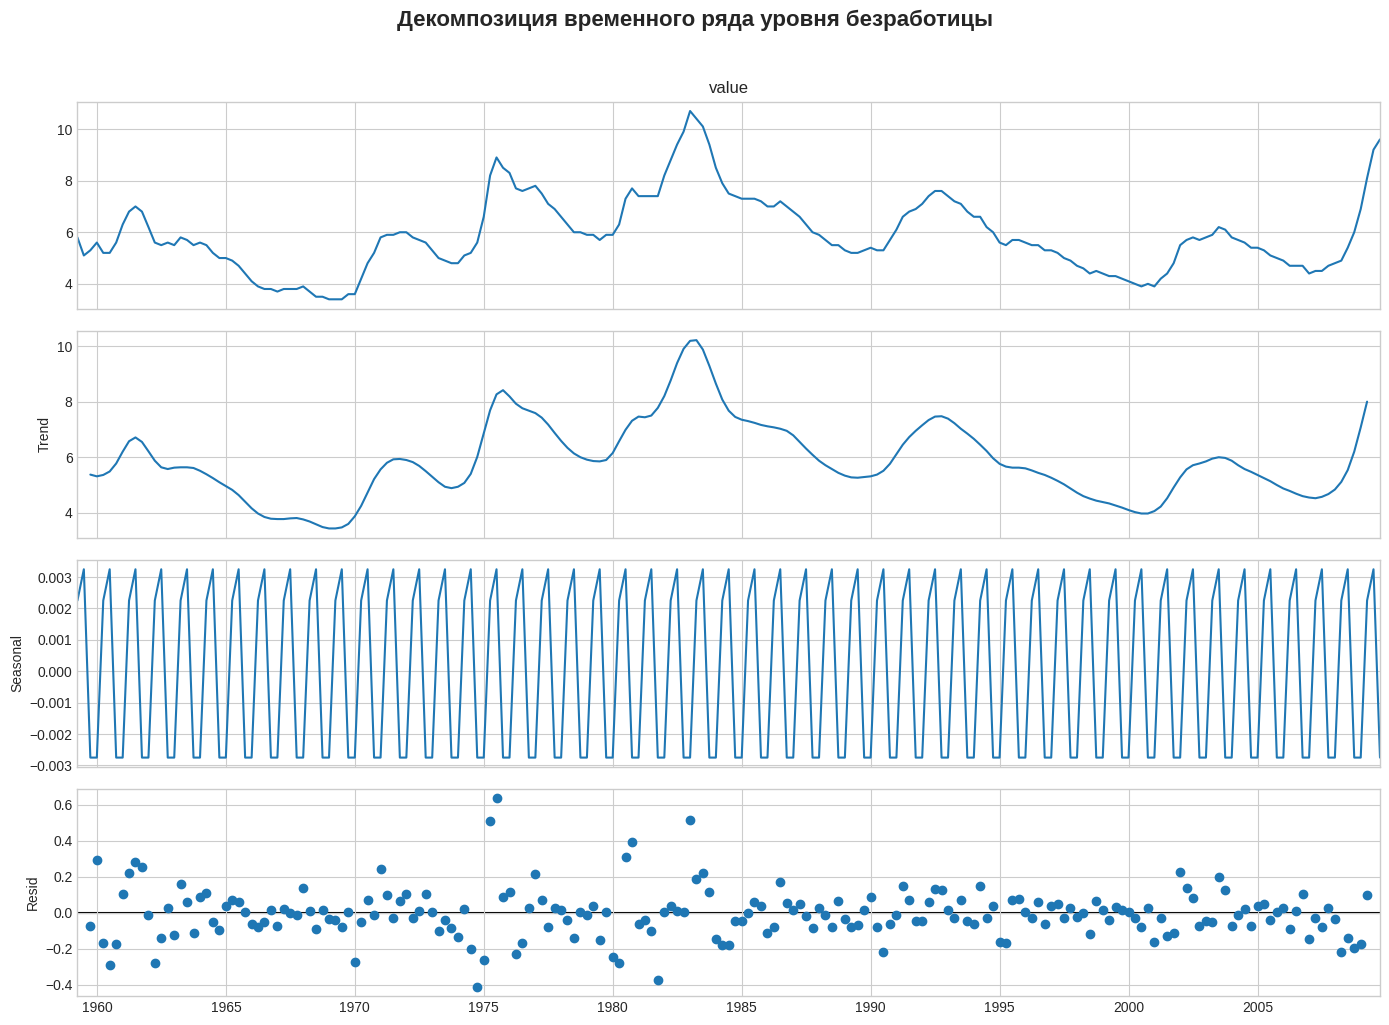

In [54]:
# --- Пункт 2 ---
print("ДЕКОМПОЗИЦИЯ ВРЕМЕННОГО РЯДА:")
print("="*50)

# Выполнение декомпозиции (аддитивная модель с периодом 4 для квартальных данных)
decomposition_unemployment = seasonal_decompose(unemployment_df['value'], model='additive', period=4)

# Визуализация декомпозиции
fig = decomposition_unemployment.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Декомпозиция временного ряда уровня безработицы', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


ACF и PACF для дифференцированного ряда:
ADF тест для дифференцированного ряда: p-value = 0.000745


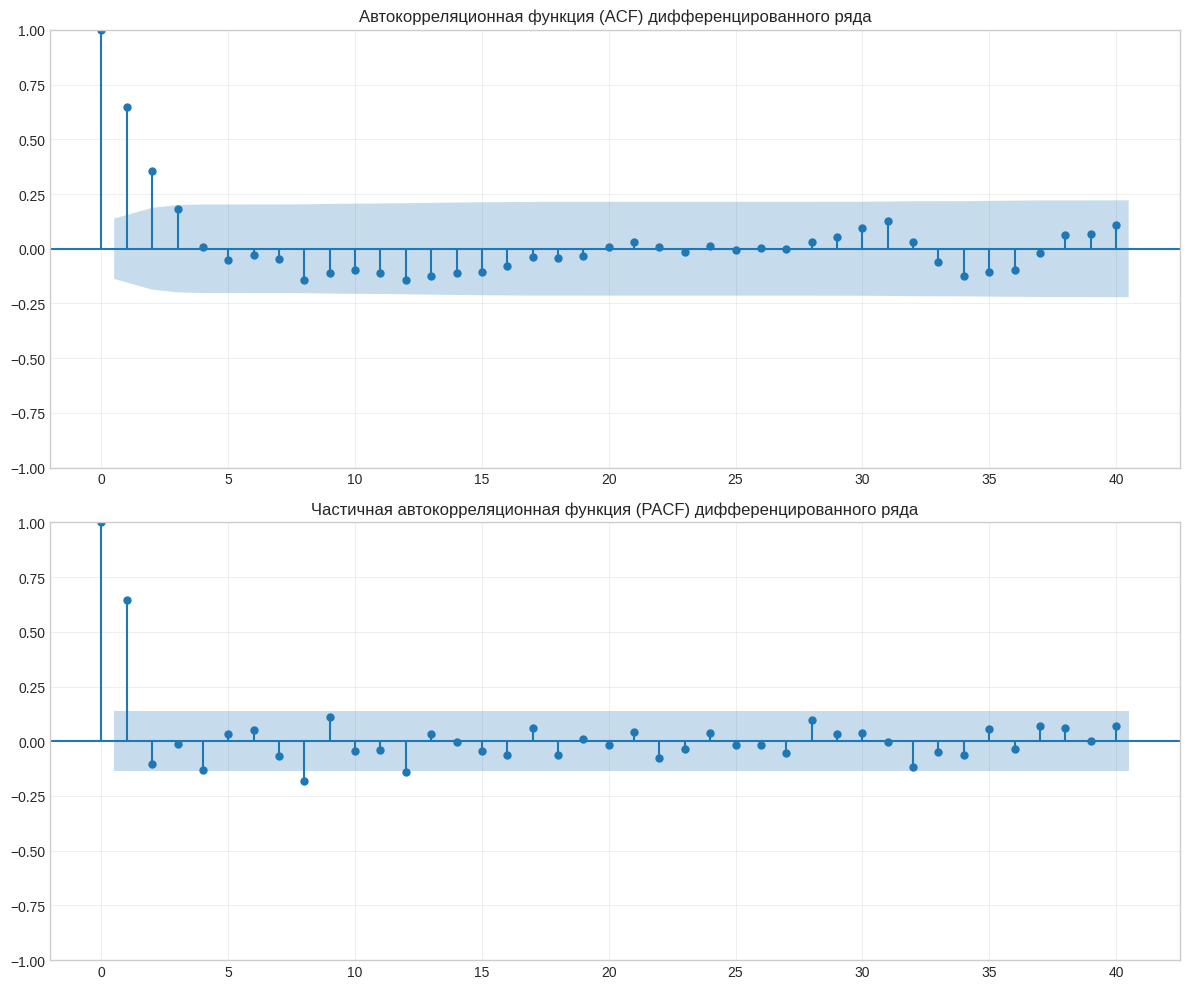

In [56]:
# --- Пункт 3 ---
# Корреляция: Постройте ACF и PACF для дифференцированного ряда
print("\nACF и PACF для дифференцированного ряда:")
print("="*50)

# Дифференцирование ряда
unemployment_diff = unemployment_df['value'].diff().dropna()

# Проверка стационарности дифференцированного ряда
adf_result = adfuller(unemployment_diff)
print(f"ADF тест для дифференцированного ряда: p-value = {adf_result[1]:.6f}")

# Построение ACF и PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# ACF
plot_acf(unemployment_diff, lags=40, ax=ax1, alpha=0.05)
ax1.set_title('Автокорреляционная функция (ACF) дифференцированного ряда', fontsize=12)
ax1.grid(True, alpha=0.3)

# PACF
plot_pacf(unemployment_diff, lags=40, ax=ax2, alpha=0.05, method='ywm')
ax2.set_title('Частичная автокорреляционная функция (PACF) дифференцированного ряда', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [57]:
# --- Пункт 4 ---
# Моделирование: Обучите ARIMA(2,1,2) на данных до 2012 года
print("\nОБУЧЕНИЕ МОДЕЛИ ARIMA(2,1,2):")
print("="*50)

# Разделение данных на обучающую (до 2012 года) и тестовую выборки
train_unemp = unemployment_df.loc[unemployment_df.index < '2012-01-01', 'value']
test_unemp = unemployment_df.loc[unemployment_df.index >= '2012-01-01', 'value']

print(f"Обучающая выборка: {len(train_unemp)} наблюдений (до 2012 года)")
print(f"Тестовая выборка: {len(test_unemp)} наблюдений (с 2012 года)")

# Создание и обучение модели ARIMA(2,1,2)
model_unemp = ARIMA(train_unemp, order=(2, 1, 2))
model_unemp_fit = model_unemp.fit()

print("\nСводка модели ARIMA(2,1,2):")
print(model_unemp_fit.summary())




ОБУЧЕНИЕ МОДЕЛИ ARIMA(2,1,2):
Обучающая выборка: 203 наблюдений (до 2012 года)
Тестовая выборка: 0 наблюдений (с 2012 года)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Сводка модели ARIMA(2,1,2):
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  203
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  -9.747
Date:                Mon, 08 Dec 2025   AIC                             29.495
Time:                        19:59:29   BIC                             46.036
Sample:                    03-31-1959   HQIC                            36.187
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5788      0.062     25.300      0.000       1.456       1.701
ar.L2         -0.6187      0.068     -9.130      0.000      -0.752      -0.486
ma.L1         -0.8719  


ПРОГНОЗ И ОЦЕНКА МОДЕЛИ:
Диапазон данных по безработице: с 1959-03-31 00:00:00 по 2009-09-30 00:00:00
Всего наблюдений: 203
Разделение на 1999-09-30 00:00:00:
Обучающая выборка: 162 наблюдений (до 1999-06-30 00:00:00)
Тестовая выборка: 41 наблюдений (с 1999-09-30 00:00:00 по 2009-09-30 00:00:00)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


RMSE на тестовом периоде: 1.1242


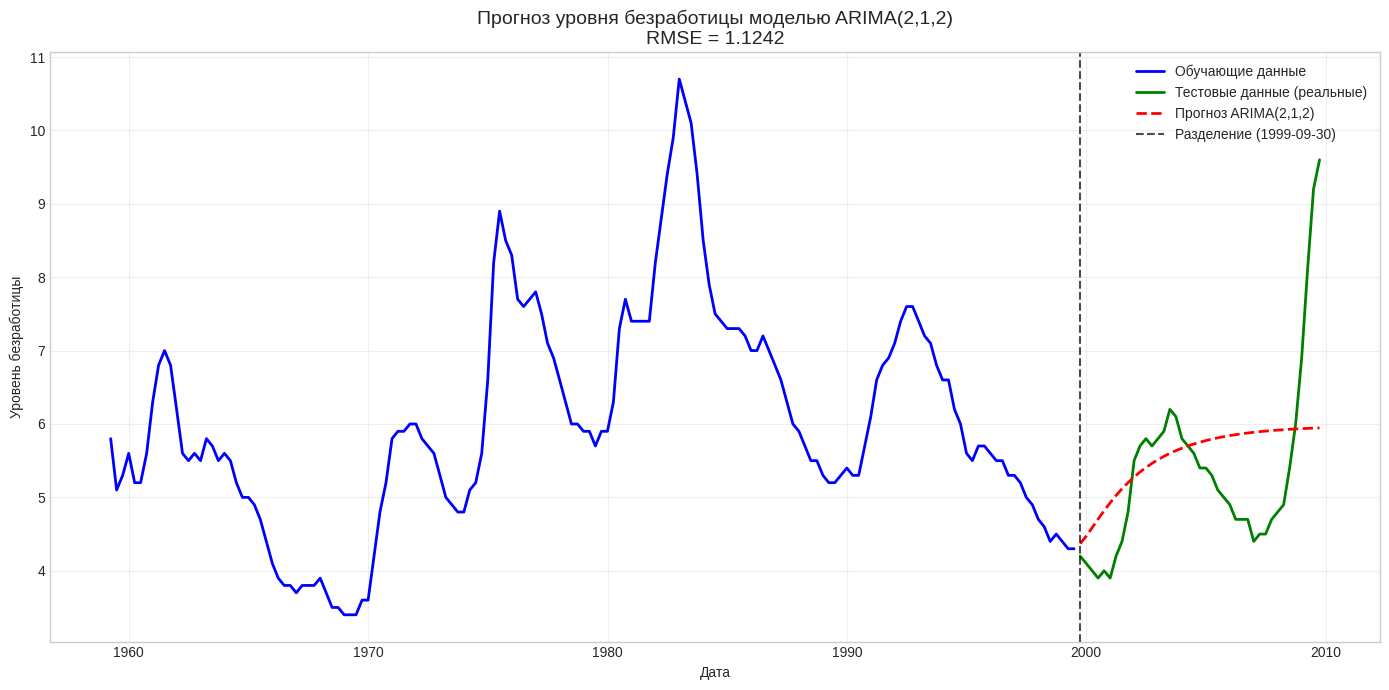

In [58]:
# --- Пункт 5 ---
# Прогноз: Визуализируйте прогноз на тестовом периоде и рассчитайте RMSE
print("\nПРОГНОЗ И ОЦЕНКА МОДЕЛИ:")
print("="*50)

# Проверим данные
print(f"Диапазон данных по безработице: с {unemployment_df.index.min()} по {unemployment_df.index.max()}")
print(f"Всего наблюдений: {len(unemployment_df)}")

# Разделим данные на обучающую и тестовую выборки
# Так как данные заканчиваются в 2009 году, а задание требует обучения до 2012 года,
# возьмем 80% данных для обучения, 20% для тестирования
split_index = int(len(unemployment_df) * 0.8)
train_unemp = unemployment_df.iloc[:split_index, 0]
test_unemp = unemployment_df.iloc[split_index:, 0]
split_date = test_unemp.index[0]

print(f"Разделение на {split_date}:")
print(f"Обучающая выборка: {len(train_unemp)} наблюдений (до {train_unemp.index[-1]})")
print(f"Тестовая выборка: {len(test_unemp)} наблюдений (с {test_unemp.index[0]} по {test_unemp.index[-1]})")

# Переобучаем модель на новой обучающей выборке
model_unemp = ARIMA(train_unemp, order=(2, 1, 2))
model_unemp_fit = model_unemp.fit()

# Создание прогноза на тестовый период
forecast_unemp = model_unemp_fit.predict(start=test_unemp.index[0], end=test_unemp.index[-1])

# Расчет RMSE
rmse_unemp = np.sqrt(mean_squared_error(test_unemp, forecast_unemp))
print(f"RMSE на тестовом периоде: {rmse_unemp:.4f}")

# Визуализация прогноза
plt.figure(figsize=(14, 7))

# Обучающие данные
plt.plot(train_unemp.index, train_unemp, 'b-', linewidth=2, label='Обучающие данные')

# Тестовые данные (реальные значения)
plt.plot(test_unemp.index, test_unemp, 'g-', linewidth=2, label='Тестовые данные (реальные)')

# Прогноз модели
plt.plot(forecast_unemp.index, forecast_unemp, 'r--', linewidth=2, label='Прогноз ARIMA(2,1,2)')

# Линия разделения
plt.axvline(x=split_date, color='black', linestyle='--',
            alpha=0.7, label=f'Разделение ({split_date.date()})')

# Настройка графика
plt.title(f'Прогноз уровня безработицы моделью ARIMA(2,1,2)\nRMSE = {rmse_unemp:.4f}', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Уровень безработицы')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
